# Homework 7

## UW PCE Data Science: Methods for Data Analysis

Description:

Perform Principle Component Regression on a dataset that tracked patients with Parkinson's Disease.

Citation: A Tsanas, MA Little, PE McSharry, LO Ramig (2009)
'Accurate telemonitoring of Parkinson's disease progression by non-invasive speech tests',
IEEE Transactions on Biomedical Engineering.

About the data:
This dataset is composed of a range of biomedical voice measurements from 42 
people with early-stage Parkinson's disease recruited to a six-month trial of 
a telemonitoring device for remote symptom progression monitoring. The 
recordings were automatically captured in the patient's homes.

Steps:

 1. Load the dataset.
 2. Create the X-matrix (one-hot encoding categorical factors).
 3. Scale the X-matrix.
 4. Create the principle components and do a simple plot of the explained variance.
 5. PCR - Linear regression with the principle components.

Report on:

 1. Number of components before and after (choose a smaller number of principle components and explain how you chose them).
 2. Interpret the adjusted R-squared.

In [78]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns

In [79]:
parkinsons_df = pd.read_csv('parkinsons_updrs.data')
parkinsons_df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [80]:
parkinsons_df.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

In [81]:
# Define the target and features:
target_label = 'total_UPDRS'
non_features = ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS']
feature_labels = [x for x in parkinsons_df.columns if x not in [target_label] + non_features]

# Filter out non-features and non-targets
parkinsons_df = parkinsons_df.drop(non_features, axis=1)

# One-hot encode inputs
parkinsons_expanded = pd.get_dummies(parkinsons_df, drop_first=True)
print('DataFrame one-hot-expanded shape: {}'.format(parkinsons_expanded.shape))

# Get target and original x-matrix
y = parkinsons_df[target_label]
X = parkinsons_df.as_matrix(columns=feature_labels)



DataFrame one-hot-expanded shape: (5875, 17)


In [82]:
parkinsons_df.head(5)

,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [83]:
# Scale function
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

In [84]:
# Scale all columns first
parkinsons_df = scale(parkinsons_df)

# Create x-scaled (look into the function np.apply_along_axis to apply 'scale' function to each column)
#X_scaled = scale(X) - x SEEMS TO BE SCALED....

# Create a scaled y-target
y_scaled = scale(y)
parkinsons_df.head(5)

,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,0.502745,0.082905,-0.284242,0.327453,-0.028637,0.328505,-0.324594,-0.351642,-0.209709,-0.423356,-0.543466,-0.209704,-0.298721,-0.009205,-1.214066,-1.478500,-0.650658
1,0.549103,-0.560793,-0.756723,-0.533746,-0.476212,-0.534825,-0.534016,-0.573156,-0.545158,-0.565592,-0.529955,-0.545153,-0.351965,1.282650,-1.055119,-1.247880,-1.218585
2,0.595367,-0.238944,-0.539382,-0.300038,-0.320767,-0.298983,-0.669115,-0.564469,-0.741592,-0.702426,-0.645545,-0.741587,-0.199370,0.318711,-0.784860,-1.540139,-0.103280
3,0.634716,-0.155370,-0.485186,-0.344859,-0.170682,-0.344871,-0.423692,0.069668,-0.460540,-0.449763,-0.392849,-0.460787,-0.071754,0.644530,-0.536487,-1.062115,1.237075
4,0.687522,-0.498557,-0.663894,-0.658604,-0.529814,-0.659682,-0.658276,-0.586186,-0.783145,-0.651413,-0.464905,-0.783392,-0.343370,1.036305,-0.689195,-1.297953,-0.283954


In [85]:
#check function...
mean =np.mean(parkinsons_df['total_UPDRS'])
std = np.std(parkinsons_df['total_UPDRS'])
scaled=(parkinsons_df['total_UPDRS']-mean)/std
scaled.head(5)

0    0.502745
1    0.549103
2    0.595367
3    0.634716
4    0.687522
Name: total_UPDRS, dtype: float64

In [86]:
# PCA!! (Primary Component Analysis)
pca = PCA()
pca_result =  pca.fit_transform(X)

column_names = ['pc' + str(ix+1) for ix in range(X.shape[1])]
pca_df = pd.DataFrame(data = pca_result, columns=column_names)
pca_df[target_label] = y_scaled
print(pca_df.head())
print(pca_df.shape)

        pc1       pc2       pc3       pc4       pc5       pc6       pc7  \
0  0.032262 -0.063082 -0.160399 -0.075797 -0.036048 -0.020489  0.003958   
1 -5.506490  0.119718 -0.027369 -0.048629 -0.009077  0.002927  0.000151   
2 -1.373763 -0.055115 -0.073258 -0.064052 -0.083374 -0.015379 -0.006209   
3 -2.760920  0.144331  0.047901  0.032369 -0.145759 -0.042199 -0.014273   
4 -4.449132  0.068235  0.009236 -0.034520 -0.068758 -0.012732 -0.006856   

        pc8       pc9      pc10      pc11      pc12      pc13      pc14  \
0 -0.004517  0.008281 -0.000183  0.000860 -0.000365 -0.000109 -0.000002   
1  0.002084  0.001933 -0.000662  0.000745  0.000243 -0.000119 -0.000005   
2 -0.003317  0.000595 -0.000291  0.000013  0.000084 -0.000318  0.000005   
3 -0.013032 -0.007849 -0.001435 -0.003835  0.000429  0.000300  0.000015   
4  0.001855 -0.001202 -0.000238  0.000084  0.000276 -0.000377  0.000002   

       pc15          pc16  total_UPDRS  
0  0.000003 -1.894103e-06     0.502745  
1 -0.000003  1.9

explained variance Ratio: [  9.98058261e-01   1.12840639e-03   3.16876080e-04   2.80064016e-04
   1.46644309e-04   5.92901278e-05   5.65474114e-06   2.45294929e-06
   1.74490141e-06   3.68703654e-07   1.84119300e-07   3.80453852e-08
   1.49387901e-08   1.02796863e-11   3.62219655e-13   3.52124297e-13]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

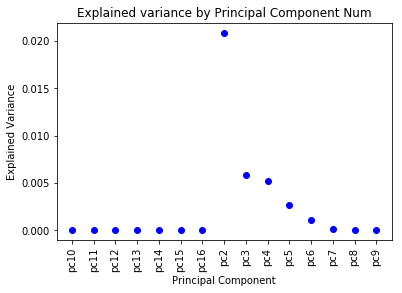

In [109]:
# Plot the explained variance for all 16 principal components
exp_var =pca.explained_variance_
print('explained variance Ratio:', pca.explained_variance_/sum(exp_var)) # % of the explained variance per component

# Note: If the first value is too large, it may dwarf how the rest look.
#   You may consider plotting starting with the 2nd value (python index at 1)
plt.plot(column_names[1:16],exp_var[1:16], 'bo') #not plotting in order and i dont know why!
plt.title('Explained variance by Principal Component Num')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(rotation='vertical')


(array([ -2.,   0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.]),
 <a list of 10 Text xticklabel objects>)

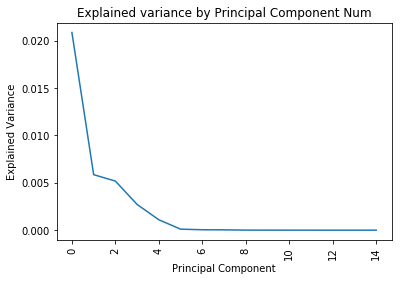

In [111]:
plt.plot(exp_var[1:16]) #plots in order without column names
plt.title('Explained variance by Principal Component Num')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(rotation='vertical')


                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     86.41
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           1.04e-37
Time:                        01:11:06   Log-Likelihood:                -8251.1
No. Observations:                5875   AIC:                         1.651e+04
Df Residuals:                    5872   BIC:                         1.653e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -4.38e-15      0.013  -3.41e-13      1.0

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


Text(0.5,1,'Residual Histogram')

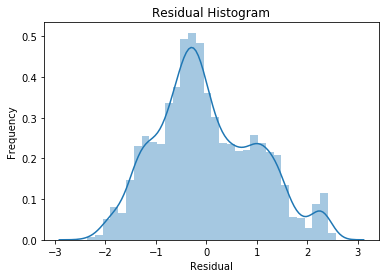

In [104]:
# Perform linear regression with the first N columns
n =2 #the first two pricipal components represent 0.998 + 0.001128 = 99.9128% of the dataset's explained variance
formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

In [89]:
#what are the max values of each feature
parkinsons_df.max()

total_UPDRS       2.427531
Jitter(%)        16.685707
Jitter(Abs)      11.160633
Jitter:RAP       17.464987
Jitter:PPQ5      17.764476
Jitter:DDP       17.465979
Shimmer           9.081220
Shimmer(dB)       7.800931
Shimmer:APQ3     10.993835
Shimmer:APQ5      8.814745
Shimmer:APQ11    12.408608
Shimmer:DDA      10.994080
NHR              11.998215
HNR               3.774533
RPDE              4.204980
DFA               2.995380
PPE               5.597736
dtype: float64

(5875,)


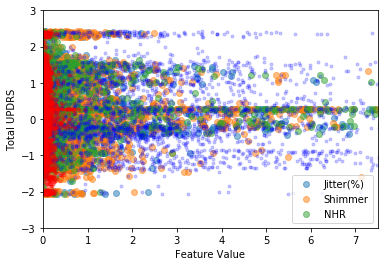

In [112]:
#check relation between features of relative similar maginitudes and total UPDRS
plt1 = plt.scatter(parkinsons_df['Jitter(%)'],y_scaled, alpha =0.5)
plt2 = plt.scatter(parkinsons_df['Shimmer'],y_scaled, alpha =0.5)
plt3 = plt.scatter(parkinsons_df['NHR'],y_scaled, alpha =0.5)
plt.legend([plt1,plt2,plt3], ['Jitter(%)','Shimmer', 'NHR'])
plt.xlim(0,7.5)
plt.ylim(-3,3)
plt.ylabel('Total UPDRS')
plt.xlabel('Feature Value')
plt.plot(pca_df['pc1'], y_scaled, 'b.', alpha =0.2) #multidimensional --> wont show up as a line!
plt.plot(pca_df['pc2'], y_scaled, 'r.', alpha =0.2)#multidimensional --> wont show up as a line!
print(y_scaled.shape)

Text(0.5,0,'Feature Value')

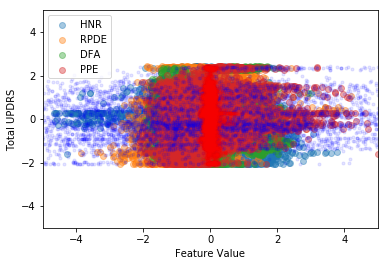

In [114]:
#check distribution/correlation between features with similar (lower) max values and total UPDRS
plt1 = plt.scatter(parkinsons_df['HNR'],y_scaled, alpha =0.4)
plt2 = plt.scatter(parkinsons_df['RPDE'],y_scaled, alpha =0.4)
plt3 = plt.scatter(parkinsons_df['DFA'],y_scaled, alpha =0.4)
plt4 = plt.scatter(parkinsons_df['PPE'],y_scaled, alpha =0.4)
plt.plot(pca_df['pc1'],y_scaled,'b.', alpha =0.1 ) #multidimensional --> wont show up as a line!
plt.plot(pca_df['pc2'], y_scaled , 'r.',alpha =0.1)#multidimensional --> wont show up as a line!
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.legend([plt1,plt2,plt3,plt4], ['HNR','RPDE', 'DFA','PPE'])
plt.ylabel('Total UPDRS')
plt.xlabel('Feature Value')

### Summary of my results!

1. The number of principal components for the data frame analyzed was 16. After determining the explained variance of each principal component, it was determined that pc1 and pc2 make up 0.998 + 0.001128 = 99.9128% of the total explained variance. This was calculated by dividing each explained variance by the total/cummulative explained variance for all 16 principal components. Thus, the first two pc's provide more than sufficient detail to use PCR to predict y_scaled values of total UPDRS values.

2. The Adjusted R-squared value from PCR using principal components 1 and 2 is 0.028. Adjusted R-squared accounts for multiple independent variables to determine the R-squared value given a sample size. The value of 0.028 out of a maximum value of 1 tells us that the linear regression model through PCR is not representative of the spread in the dataset. E.g. there is a large distance between the vast majority of the data points and the linear regression model. As shown in the scatter plots above, there is a lot of spread in the data and a linear regression model is not the best model to use to represent and predict total UPDRS values.